In [ ]:
# Get the uniprot mapping IDs
# ! wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz

# Grep mapping ids to string only
# ! grep STRING HUMAN_9606_idmapping.dat > string.map


# Get string interactions
# ! wget https://stringdb-static.org/download/protein.links.v11.5/9606.protein.links.v11.5.txt.gz

In [1]:
import pandas as pd

In [2]:
dfmap = pd.read_csv('../data/string.map', sep='\t', names=['protid', 'db', 'ensmbl'])
dfstring = pd.read_csv('../data/9606.protein.links.v12.0.txt', sep=' ')
df = pd.read_csv('only_pc_results/syn_results/final_results.tsv', sep='\t')

In [49]:
df.snps.drop_duplicates()

0                       P10644*Q9NYF8
1                       Q14677*Q8NEY8
2                       P50336*Q14677
3                       P50336*Q9UKV5
4                       Q08752*Q6NUK1
                     ...             
824822    O43159*Q9BUH6*Q9UBI6*Q92785
824823    P29992*P50336*Q92667*Q96JQ2
824824    O60271*O94880*P09758*Q9BVV7
824825    O00754*P62316*Q9BT09*Q9BXJ9
824826    P07942*P52272*Q13685*Q9NY27
Name: snps, Length: 742466, dtype: object

In [50]:
dfmap.head()

,protid,db,ensmbl
0,P31946,STRING,9606.ENSP00000361930
1,P62258,STRING,9606.ENSP00000264335
2,Q04917,STRING,9606.ENSP00000248975
3,P61981,STRING,9606.ENSP00000306330
4,P31947,STRING,9606.ENSP00000340989


In [51]:
dfstring.combined_score.min()

150

In [52]:
def undo(string):    
    string = ''.join([ x if ord(x)<91 else str(ord(x)-97) for x in string ])
    string = string[:6]+'.'+string[6:].replace('HUMAN', '_HUMAN') #not sure these 6
    return string


In [3]:
#Getting second order interactions
df = df[df.order == 2]
# df['prots'] = df.snps.apply(lambda x: x.split('.')[0]+'+'+x.split('*')[1].split('.')[0])
df['prots'] = df.snps.str.replace('*', '+')
df.head()

C:\Users\wen068\AppData\Local\Temp\ipykernel_20056\4268088652.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['prots'] = df.snps.str.replace('*', '+')


,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug,prots
0,Pbagee:QjNYFi,0.256486,0.113,2.273635,0.023328,0.034953,0.478019,625,0.009699,True,P10644*Q9NYF8,2,CHEMBL109480,P10644+Q9NYF8
1,Qbeghh:QiNEYi,0.022985,0.019,1.211605,0.226124,-0.014270,0.060240,625,0.005295,True,Q14677*Q8NEY8,2,CHEMBL109480,Q14677+Q8NEY8
2,Pfaddg:Qbeghh,-0.015988,0.022,-0.727467,0.467214,-0.059146,0.027171,625,0.031992,True,P50336*Q14677,2,CHEMBL109480,P50336+Q14677
3,Pfaddg:QjUKVf,0.000117,0.007,0.017571,0.985986,-0.013000,0.013235,625,0.041778,True,P50336*Q9UKV5,2,CHEMBL109480,P50336+Q9UKV5
4,Qaihfc:QgNUKb,-0.018627,0.028,-0.668619,0.503987,-0.073335,0.036081,625,0.003025,True,Q08752*Q6NUK1,2,CHEMBL109480,Q08752+Q6NUK1


In [54]:
df['prots'] = df.prots.apply(lambda x: x[:6]+'+'+x.split('+')[1][:6])

In [4]:
# Applying bonferroni for multiple testing
from  statsmodels.stats.multitest import multipletests
df['p_fdr'] = 1  
correction = 'fdr_bh'

f = 0.2
df = df[abs(df.coef) > f]

# do the correction per order
for d in df.drug.unique():
    if df[df.drug == d].shape[0] == 0: continue
    df.loc[df.drug == d, 'p_fdr'] = multipletests(df['P>|z|'][df.drug == d], method=correction)[1]
df.head()

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug,prots,p_fdr
0,Pbagee:QjNYFi,0.256486,0.113,2.273635,0.023328,0.034953,0.478019,625,0.009699,True,P10644*Q9NYF8,2,CHEMBL109480,P10644+Q9NYF8,0.057727
19,Qbcjfj:QjgTcd,-0.271522,0.103,-2.648542,0.008289,-0.472845,-0.070199,625,0.023346,True,Q12959*Q96T23,2,CHEMBL109480,Q12959+Q96T23,0.032284
45,Pffhdf:Qbfeci,0.231420,0.276,0.837970,0.402370,-0.310914,0.773754,625,0.003885,True,P55735*Q15428,2,CHEMBL109480,P55735+Q15428,0.413572
72,Pfbbei:Qbcjfj,0.213529,0.094,2.274629,0.023268,0.029180,0.397879,625,0.010724,True,P51148*Q12959,2,CHEMBL109480,P51148+Q12959,0.057727
76,Pdabab:Pgchfd,0.438490,0.192,2.283092,0.022762,0.061325,0.815656,625,0.041594,True,P30101*P62753,2,CHEMBL109480,P30101+P62753,0.057402


In [5]:
# Mapping DB string to uniprot IDs
dfmapped = dfstring.merge(dfmap, left_on='protein1', right_on='ensmbl').merge(dfmap, left_on='protein2', right_on='ensmbl')

#Making the interactions the same way my tool does them
dfmapped = dfmapped[['protein1','protein2','combined_score','protid_x','protid_y']]
dfmapped['combined_col'] = dfmapped.apply(lambda row:'+'.join(sorted([row['protid_x'], row['protid_y']])), axis=1) #inefficient, takes a while. Probably faster with if, else function
dfmapped.drop_duplicates('combined_col', keep='first', inplace=True)

In [11]:
dfmapped.head()

,protein1,protein2,combined_score,protid_x,protid_y,combined_col
0,9606.ENSP00000000233,9606.ENSP00000356607,173,P84085,Q86X27,P84085+Q86X27
1,9606.ENSP00000005257,9606.ENSP00000356607,732,P11233,Q86X27,P11233+Q86X27
2,9606.ENSP00000012049,9606.ENSP00000356607,154,Q9NXS2,Q86X27,Q86X27+Q9NXS2
3,9606.ENSP00000085219,9606.ENSP00000356607,204,P20273,Q86X27,P20273+Q86X27
4,9606.ENSP00000155840,9606.ENSP00000356607,155,P51787,Q86X27,P51787+Q86X27


In [6]:
#Combining string and RF
dfcombi = df.merge(dfmapped, left_on='prots', right_on='combined_col')

In [7]:
uni_to_prot = pd.read_csv('data/uniprot_protein.csv').set_index('UniProt')


In [8]:
dfcombi.protid_x = uni_to_prot.loc[dfcombi.protid_x].values
dfcombi.protid_y = uni_to_prot.loc[dfcombi.protid_y].values

In [27]:
dfcombi[dfcombi.drug == 'CHEMBL603469'].sort_values('p_fdr')

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,...,order,drug,prots,p_fdr,protein1,protein2,combined_score,protid_x,protid_y,combined_col
5864,Ojfiib:Qjjeec,-0.369393,0.084,-4.405033,0.000012,-0.534070,-0.204716,627,0.053121,True,...,2,CHEMBL603469,O95881+Q99442,0.000911,9606.ENSP00000337688,9606.ENSP00000360688,156,SEC62,TXD12,O95881+Q99442
5956,Obejai:Qbfcih,-0.291125,0.066,-4.394527,0.000013,-0.421220,-0.161030,627,0.036167,True,...,2,CHEMBL603469,O14908+Q15287,0.000911,9606.ENSP00000457723,9606.ENSP00000376753,152,RNPS1,GIPC1,O14908+Q15287
5858,Pffaib:Qbfdgg,0.852223,0.209,4.068368,0.000053,0.440859,1.263586,627,0.086096,True,...,2,CHEMBL603469,P55081+Q15366,0.002237,9606.ENSP00000267812,9606.ENSP00000352438,193,MFAP1,PCBP2,P55081+Q15366
5921,Pffaib:QjUQia,0.528946,0.136,3.890206,0.000111,0.261934,0.795958,627,0.067268,True,...,2,CHEMBL603469,P55081+Q9UQ80,0.004032,9606.ENSP00000267812,9606.ENSP00000302886,194,MFAP1,PA2G4,P55081+Q9UQ80
6001,Ojfdeh:QjUKDc,-0.202993,0.057,-3.582532,0.000367,-0.314264,-0.091721,627,0.044122,True,...,2,CHEMBL603469,O95347+Q9UKD2,0.008861,9606.ENSP00000286398,9606.ENSP00000364320,186,SMC2,MRT4,O95347+Q9UKD2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934,Oediaj:QiNbFh,-0.299730,0.370,-0.809675,0.418436,-1.026694,0.427233,627,0.012039,True,...,2,CHEMBL603469,O43809+Q8N1F7,0.424520,9606.ENSP00000310668,9606.ENSP00000300291,265,NUP93,CPSF5,O43809+Q8N1F7
5997,Pdhbji:Qbdceh,0.291346,0.369,0.789750,0.429974,-0.433110,1.015803,627,0.023933,True,...,2,CHEMBL603469,P37198+Q13247,0.435522,9606.ENSP00000244020,9606.ENSP00000471191,482,SRSF6,NUP62,P37198+Q13247
5901,Qbafha:QiWWYd,0.230069,0.340,0.675694,0.499485,-0.438583,0.898720,627,0.021391,True,...,2,CHEMBL603469,Q10570+Q8WWY3,0.503494,9606.ENSP00000484669,9606.ENSP00000324122,162,CPSF1,PRP31,Q10570+Q8WWY3
5920,Pgcdbi:Qacihi,-0.271853,0.431,-0.630789,0.528410,-1.118187,0.574482,627,0.038017,True,...,2,CHEMBL603469,P62318+Q02878,0.531797,9606.ENSP00000215829,9606.ENSP00000403172,355,SMD3,RL6,P62318+Q02878


In [19]:
top_syn = []
for d in dfcombi.drug.unique():
    top_syn.append(dfcombi[dfcombi.drug == d].sort_values('p_fdr')[['drug', 'combined_score', 'protid_x', 'protid_y']].head(3))
top_syn = pd.concat(top_syn)

In [24]:
top_syn.sort_values('drug').tail(51)

,drug,combined_score,protid_x,protid_y
3433,CHEMBL325041,306,LRC59,GANAB
3404,CHEMBL325041,844,LA,ROA2
3372,CHEMBL325041,493,RS19,HSP74
551,CHEMBL34259,197,HNRDL,MUTA
3632,CHEMBL34259,167,HNRPD,MUTA
3502,CHEMBL34259,304,DYHC1,BTF3
4149,CHEMBL413,276,NOP56,CDC5L
4095,CHEMBL413,215,TRA2A,BMS1
4173,CHEMBL413,168,RRP15,RBMX
4385,CHEMBL414804,233,UBC9,RTCB


In [25]:
2098/10029

0.20919333931598363

In [11]:

print(f'RF all considered (|coef| > {f}) interactions',len(df))
print('RF all considered interactions NOT REPEATED',len(df.drop_duplicates('snps',keep='first')))
print('overlapping string&RF interactions',len(dfcombi))
print('overlapping string&RF interactions NOT REPEATED',len(dfcombi.drop_duplicates('snps',keep='first')))
print('FDR corrected interactions', df[(df['p_fdr']<0.05)].shape[0])
print('FDR corrected interactions NOT REPEATED', df[(df['p_fdr']<0.05)].drop_duplicates('snps', keep='first').shape[0])
print('overlapping string&RF SIGNIFICANT interactions', dfcombi[(dfcombi['p_fdr']<0.05)].shape[0])
print('overlapping string&RF SIGNIFICANT interactions NOT REPEATED', dfcombi[(dfcombi['p_fdr']<0.05)].drop_duplicates('snps',keep='first').shape[0])

RF all considered (|coef| > 0.2) interactions 30182
RF all considered interactions NOT REPEATED 28616
overlapping string&RF interactions 7164
overlapping string&RF interactions NOT REPEATED 6799
FDR corrected interactions 10379
FDR corrected interactions NOT REPEATED 10029
overlapping string&RF SIGNIFICANT interactions 2163
overlapping string&RF SIGNIFICANT interactions NOT REPEATED 2098


<Axes: xlabel='combined_score', ylabel='p_fdr'>

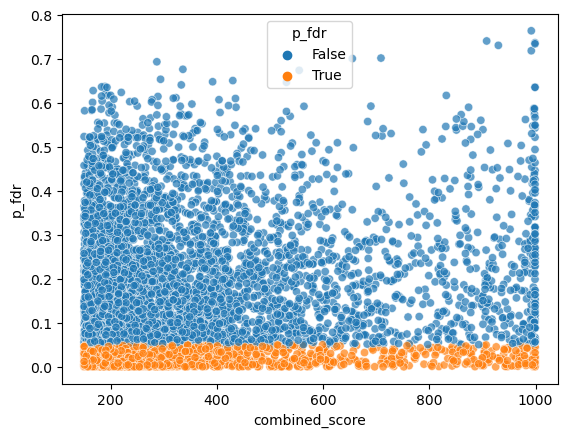

In [10]:
import seaborn as sns

sns.scatterplot(dfcombi, x='combined_score', y='p_fdr', alpha=0.7, hue=dfcombi['p_fdr']<0.05)

<Axes: >

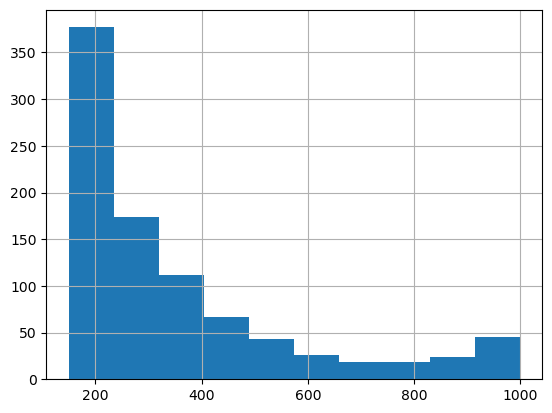

In [47]:
dfcombi[dfcombi['p_fdr']<0.05].drop_duplicates('snps').combined_score.hist()

<Axes: >

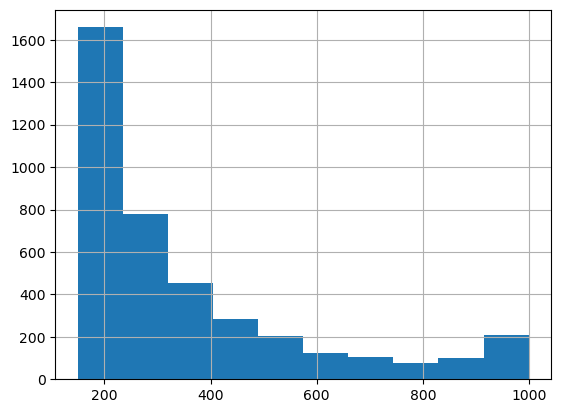

In [33]:
dfcombi.combined_score.hist()